In [21]:
##The functions I used are in the next cell. Was getting a bunch of errors when running the others about unimported packages

import pandas as pd
import csv
import json, requests, time, logging
from scipy.cluster import hierarchy
from scipy.spatial import distance
import json, requests, time, logging
from matplotlib_venn import venn3
from matplotlib_venn import venn2
plottingDF = returnPathways(ypUp, ypDn)
plotPathways(plottingDF)

def returnPathways(mygenelistUp, mygenelistDn):
    revDF = pd.DataFrame()
    for j in [mygenelistUp, mygenelistDn]:
        if len(j) != 0:
            edf = pd.concat([enrichr(map(string.upper, j), gene_set_library='KEGG_2016'), \
                     enrichr(map(string.upper, j), gene_set_library='Panther_2016'), \
                     enrichr(map(string.upper, j), gene_set_library='WikiPathways_2016')])
            sigEDF = edf[(edf['Adjusted p-value']< 0.05) & (edf['Z-score']<-1.6449)]
            trimmedEDF = sigEDF[['Term name','Overlapping genes']].set_index('Term name')
            for i, row in trimmedEDF.iterrows():
                tempDF = pd.DataFrame(row['Overlapping genes'], columns=['Genes']).set_index('Genes')
                if j == mygenelistUp:
                    tempDF[i] = 1.0
                elif j == mygenelistDn:
                    tempDF[i] = -1.0
                revDF = pd.concat([revDF,tempDF], axis=1)    
    revDF.fillna(0, inplace=True)  
    return revDF

def plotPathways(revDF): #mygenelistUp, mygenelistDn):
    #toplot = returnPathways(mygenelistUp, mygenelistDn).copy()
    if plottingDF.shape[1] <2:
        toplot = revDF.copy()
        print toplot
        print 'too few dimensions'
    else:
        toplot = revDF.copy()
        row_linkage = hierarchy.linkage(distance.pdist(np.asarray(toplot.T)), method='single')
        cg = sns.clustermap(toplot.T, row_linkage=row_linkage, figsize=(20,15), col_cluster=True, vmax=2, vmin=-2, cmap='BrBG')
        _ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
        f, ax = plt.subplots()
        sg = hierarchy.dendrogram(row_linkage, orientation='left', labels=toplot.keys(), ax=ax)


Heatmap of genelists (using a genelist and a dataframe compare_DF that has headers of 'treatment', 'name', and 'id'):

import seaborn as sns

genelist = [a for a in zList if len([i for i in rawNormalizedDF.loc[a] if i==1.0])<2 and a[:2]!='Gm' and a[:3]!='Rpl' and a[:3]!='Rps']

glist = genelist
tpm = compare_DF.copy()
tpm = tpm.reorder_levels(['treatment', 'name','id'], axis =1)
tpm.sort_index(axis=1, level=['treatment','id'], inplace=True)
toplot = tpm.copy()
toplotRatio = toplot.clip(lower=0.01).divide(control_DF.mean(1).clip(lower=0.01),axis=0)
toplotLR = log2(toplotRatio)
toplotLR = toplotLR.loc[glist]

cg = sns.clustermap(toplotLR, figsize=(20,10), col_cluster=False, vmax=3, vmin=-3)

_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)


In [38]:
#Loaded this

import pandas as pd
import csv
import json, requests, time, logging
from scipy.cluster import hierarchy
from scipy.spatial import distance
import json, requests, time, logging
from matplotlib_venn import venn3
from matplotlib_venn import venn2

def load_enrichr_genelist(glist, description='None', ):
    # returns a genelist object with two items: Ex: {"userListId": 363320,"shortId": "59lh"}
    
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/addList'

    payload = {'list': (None, '\n'.join(glist)),'description': (None, description)}
    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error analyzing gene list')
    return json.loads(response.text)

def enrichr(genelist, gene_set_library='GO_Biological_Process_2017b', description='None', sleep=1):
    
    data = load_enrichr_genelist(genelist, description=description)
    time.sleep(sleep) 
    ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
    query_string = '?userListId=%s&backgroundType=%s'
    user_list_id = data['userListId']
    response = requests.get(ENRICHR_URL + query_string % (user_list_id, gene_set_library))
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    enrichdata = json.loads(response.text)
    enrichrdf = pd.DataFrame(enrichdata.values()[0])
    print enrichrdf.shape
    if enrichrdf.shape == (0,0):
        enricherdf = pd.DataFrame(columns=['Rank', 'Term name', 'P-value', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted p-value', 'Old p-value', 'Old adjusted p-value'])
    else:
        enrichrdf.columns = ['Rank', 'Term name', 'P-value', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted p-value', 'Old p-value', 'Old adjusted p-value']
    
    loadDF(enrichrdf,'2019-7-8_3CL/HEPARG/trcl_VA/nc.flair/enrichr.csv')
    
    return enrichrdf

def loadDF(df,outname):
    df.to_csv(outname,header=True)

In [13]:
file=open('2019-7-8_3CL/HEPARG/trcl_VA/nc.flair/isosproductive.gene_list.csv')
reader=csv.reader(file,delimiter=',')
genes=[]
count=0
for row in reader:
    genes.append(row[0])
enrichr(genes)

(10004, 9)


,Rank,Term name,P-value,Z-score,Combined score,Overlapping genes,Adjusted p-value,Old p-value,Old adjusted p-value
0,1,spliceosomal complex assembly (GO:0000245),6.294745e-40,1.759368,1.588071e+02,"[EIF4A3, HNRNPU, GPATCH1, WDR83, HNRNPR, CCAR1...",6.373430e-36,0,0
1,2,spliceosomal snRNP assembly (GO:0000387),2.945645e-39,1.747220,1.550142e+02,"[EIF4A3, HNRNPU, GPATCH1, WDR83, HNRNPR, CCAR1...",1.491233e-35,0,0
2,3,spliceosomal conformational changes to generat...,3.750576e-39,1.762355,1.559313e+02,"[EIF4A3, HNRNPU, GPATCH1, WDR83, HNRNPR, CCAR1...",1.265819e-35,0,0
3,4,"alternative mRNA splicing, via spliceosome (GO...",6.256015e-39,1.756385,1.545044e+02,"[EIF4A3, HNRNPU, GPATCH1, WDR83, HNRNPR, CCAR1...",1.583554e-35,0,0
4,5,"mRNA trans splicing, via spliceosome (GO:0000365)",6.673666e-39,1.761609,1.548501e+02,"[EIF4A3, HNRNPU, GPATCH1, WDR83, HNRNPR, CCAR1...",1.351417e-35,0,0
5,6,"mRNA splicing, via spliceosome (GO:0000398)",7.092455e-39,1.736351,1.525242e+02,"[EIF4A3, HNRNPU, GPATCH1, WDR83, HNRNPR, CCAR1...",1.196852e-35,0,0
6,7,spliceosomal complex disassembly (GO:0000390),3.484463e-38,1.754081,1.512894e+02,"[EIF4A3, HNRNPU, GPATCH1, WDR83, HNRNPR, CCAR1...",5.040027e-35,0,0
7,8,"mRNA cis splicing, via spliceosome (GO:0045292)",9.905839e-38,1.747420,1.488891e+02,"[EIF4A3, HNRNPU, GPATCH1, WDR83, HNRNPR, CCAR1...",1.253708e-34,0,0
8,9,tRNA aminoacylation for protein translation (G...,2.723905e-30,1.763048,1.200204e+02,"[CARS, RPL4, RPL5, RPL30, RPL3, VARS, RPL32, R...",3.064394e-27,0,0
9,10,"nuclear-transcribed mRNA catabolic process, 3'...",2.048090e-28,1.814255,1.156687e+02,"[RPL4, RPL5, RPL30, RPL3, RPL32, RPL31, RPL34,...",2.073691e-25,0,0


In [ ]:
#Identified gene names uniquely expressed in each cell line. Obtain gene lists from isosproductive.gene_list.csv files

A431_unique=[]
SHSY5Y_unique=[]
HEPARG_unique=[]
for gene in a431_genes:
    if gene not in shsy5y_genes and gene not in heparg_genes: A431_unique.append(gene)
for gene in shsy5y_genes:
    if gene not in a431_genes and gene not in heparg_genes: SHSY5Y_unique.append(gene)
for gene in heparg_genes:
    if gene not in shsy5y_genes and gene not in a431_genes: HEPARG_unique.append(gene)
print len(A431_unique)
print len(SHSY5Y_unique)
print len(HEPARG_unique)

In [14]:
#Make lists of significant pathways

file=open('2019-7-8_3CL/A431/trcl_VA/nc.flair/enrichr.csv')
reader=csv.reader(file,delimiter=',')
next(reader)
a431=[]
for row in reader:
    if float(row[7])<.05: a431.append(row[2])

file=open('2019-7-8_3CL/SHSY5Y/trcl_VA/nc.flair/enrichr.csv')
reader=csv.reader(file,delimiter=',')
next(reader)
shsy5y=[]
for row in reader:
    if float(row[7])<.05: shsy5y.append(row[2])

file=open('2019-7-8_3CL/HEPARG/trcl_VA/nc.flair/enrichr.csv')
reader=csv.reader(file,delimiter=',')
next(reader)
heparg=[]
for row in reader:
    if float(row[7])<.05: heparg.append(row[2])

print len(a431)
print len(shsy5y)
print len(heparg)

1798
1266
1267


<matplotlib_venn._common.VennDiagram instance at 0x7fb3286c5128>

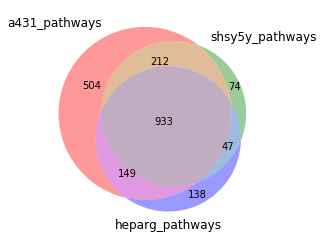

In [15]:
venn3([set(a431),set(shsy5y),set(heparg)],set_labels = ('a431_pathways','shsy5y_pathways','heparg_pathways'))

In [16]:
##Make lists of expressed genes

file=open('2019-7-8_3CL/HEPARG/trcl_VA/nc.flair/isosproductive.gene_list.csv')
reader=csv.reader(file,delimiter=',')
heparggenes=[]
count=0
for row in reader:
    heparggenes.append(row[0])
print len(heparggenes)

file=open('2019-7-8_3CL/SHSY5Y/trcl_VA/nc.flair/isosproductive.gene_list.csv')
reader=csv.reader(file,delimiter=',')
shsy5ygenes=[]
count=0
for row in reader:
    shsy5ygenes.append(row[0])
print len(shsy5ygenes)

file=open('2019-7-8_3CL/A431/trcl_VA/nc.flair/isosproductive.gene_list.csv')
reader=csv.reader(file,delimiter=',')
a431genes=[]
count=0
for row in reader:
    a431genes.append(row[0])
print len(a431genes)

8850

<matplotlib_venn._common.VennDiagram instance at 0x7fb329e8edd0>

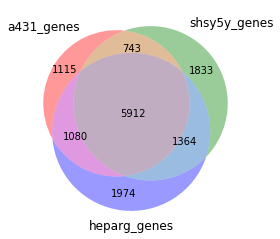

In [17]:
venn3([set(a431genes),set(shsy5ygenes),set(heparggenes)],set_labels = ('a431_genes','shsy5y_genes','heparg_genes'))

In [19]:
##Make lists of genes from direct-RNA and cdna sequencing protocols

file=open('2019-7-22_dirrna/trcl_VA/nc.flair/isosproductive.gene_list.csv')
reader=csv.reader(file,delimiter=',')
dirrna=[]
count=0
for row in reader:
    dirrna.append(row[0])
print len(dirrna)

file=open('2019-8-6_cdna/liver.merged/isosproductive.gene_list.csv')
reader=csv.reader(file,delimiter=',')
pcrcdna=[]
count=0
for row in reader:
    pcrcdna.append(row[0])
print len(pcrcdna)

3275

<matplotlib_venn._common.VennDiagram instance at 0x7fb326b71248>

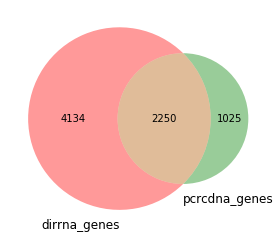

In [22]:
venn2([set(dirrna),set(pcrcdna)],set_labels = ('dirrna_genes','pcrcdna_genes'))

99


<matplotlib_venn._common.VennDiagram instance at 0x7fb3267db908>

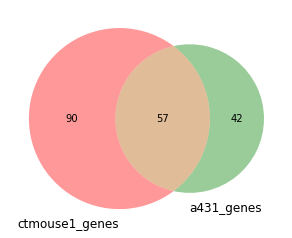

In [33]:
#Make lists of genes expressed by trangenic vs cell line (chr21)
file=open('2019-7-26_cdna/ctmouse1/nc.flair/isosproductive.gene_list.csv')
reader=csv.reader(file,delimiter=',')
ctmouse1genes=[]
count=0
for row in reader:
    ctmouse1genes.append(row[0])
print len(ctmouse1genes)

file=open('2019-7-8_3CL/A431/isosproductive.gene_list.csv')
reader=csv.reader(file,delimiter=',')
a431chr21genes=[]
count=0
for row in reader:
    a431chr21genes.append(row[0])
print len(a431chr21genes)
venn2([set(ctmouse1genes),set(a431chr21genes)],set_labels = ('ctmouse1_genes','a431_genes'))

In [40]:
#debug code to identify strange or non-genes in gene list file (eg: FP671120.1-miRNA)

file=open('2019-7-26_cdna/ctmouse1/nc.flair/isosproductive.gene_list.csv')
reader=csv.reader(file,delimiter=',')
a431chr21genes=[]
count=0
for row in reader:
    if '.' in row[0]: count+=1
print count

!grep '.' 2019-7-26_cdna/ctmouse1/nc.flair/isosproductive.gene_list.csv|head

22
0,1
FP671120.1,8
FAM3B,1
AP001136.1,1
RPL23P2,1
USP25,5
SON,6
FP236383.1,6
TPTE,5
ITSN1,1
